In [94]:
### LIBRARIES
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import inputValidation
import portfolioAllocation
import importlib
import allocationModel
import json


### PRICE TIME SERIES DATAFRAME
data = pd.read_csv("/Users/andrei/Documents/asset-allocation-data/processed/2024-02-25/equities_2024-02-25.csv")
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)

In [99]:
with open('/Users/andrei/Documents/GitHub/asset-allocation/markets_mapping.JSON', 'r') as file:
    data = json.load(file)

filtered_data = {key: value for key, value in data.items() if value}

# Print the filtered dictionary
print(json.dumps(filtered_data, indent=4))

markets = []
asset_classes = []

for asset_class, items in data.items():
    for item in items:
        markets.append(item['market'])
        asset_classes.append(asset_class)

# Create the DataFrame
df = pd.DataFrame({'market': markets, 'asset_class': asset_classes})
print(df)

allocation_constraints = [["ASIA_PACIFIC_LARGE_MID_CAP", "<", "0.3", "absolute"],
                          ["HONG_KONG_LARGE_CAP", "<", "0.1", "relative"]]

print(allocation_constraints)



{
    "Fixed Income": [
        {
            "market": "USA_GOV_BOND",
            "index_name": "S&P U.S. Government/Credit Bond Index",
            "data_source": "sp",
            "index_id_in_ds": "92351588",
            "url": "https://www.spglobal.com/spdji/en/indices/fixed-income/sp-us-government-credit-bond-index/"
        },
        {
            "market": "AFRICA_SOVEREIGN_BOND",
            "index_name": "S&P Africa Sovereign Bond Index",
            "data_source": "sp",
            "index_id_in_ds": "92024573",
            "url": "https://www.spglobal.com/spdji/en/indices/fixed-income/sp-africa-sovereign-bond-index/"
        },
        {
            "market": "CHINA_GOV_BOND",
            "index_name": "S&P China Government Bond Index",
            "data_source": "sp",
            "index_id_in_ds": "91880649",
            "url": "https://www.spglobal.com/spdji/en/indices/fixed-income/sp-china-government-bond-index/"
        },
        {
            "market": "EURO_SOVEREIG

In [88]:
data.columns

Index(['ASIA_PACIFIC_LARGE_MID_CAP', 'EMERGING_MARKETS_LARGE_MID_CAP',
       'EUROPE_LARGE_CAP', 'HONG_KONG_LARGE_CAP', 'USA_LARGE_CAP',
       'USA_SMALL_CAP'],
      dtype='object')

In [72]:
importlib.reload(inputValidation)
importlib.reload(portfolioAllocation)

portfolioAllocation.validate(data)

Warning! Number of rows with missing values (2044) is higher than 20.0% of total rows (4458)
Percentage of missing rows: 45.85%
+---------------------+--------+--------------------------+
|      Test name      | Passed |       Test values        |
+---------------------+--------+--------------------------+
| Missing values test | False  | 0.4585015702108569 > 0.2 |
|  Time series length |  True  |        2414 > 756        |
+---------------------+--------+--------------------------+


In [83]:
importlib.reload(portfolioAllocation)
importlib.reload(allocationModel)

log_returns = portfolioAllocation.getLogReturns(data)
risk_free_rate = 0.03
expected_returns = portfolioAllocation.getExpectedReturns(log_returns, calendarized = True) * 252
cov_matrix = portfolioAllocation.getCovarianceMatrix(log_returns, calendarized = True) * 252

my_model = allocationModel.markowitzModel(expected_returns = expected_returns,
                                          cov_matrix = cov_matrix,
                                          risk_free_rate = risk_free_rate)

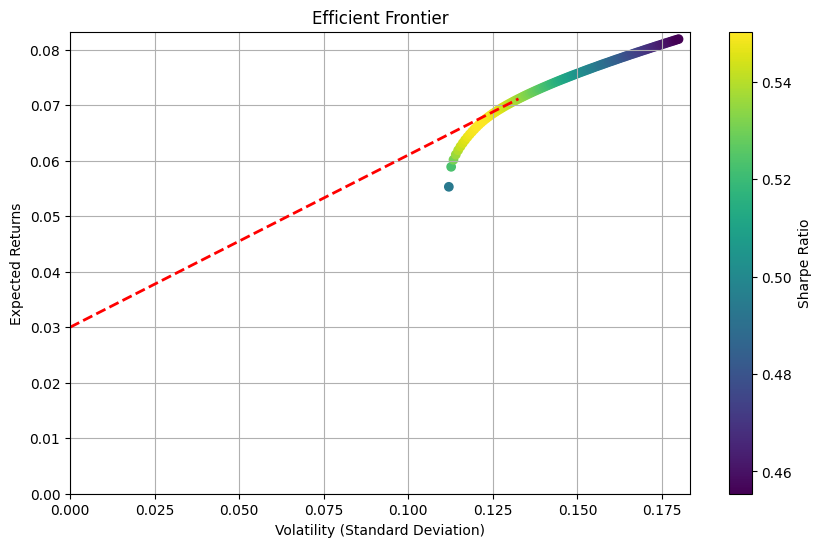

In [87]:
pf = my_model.calculateEfficientFrontier(short_selling=False)

# Calculate Sharpe ratio for each portfolio
pf['sharpe_ratio'] = (pf['returns'] - risk_free_rate) / pf['volatility']

# Find portfolio with maximum Sharpe ratio
max_sharpe_portfolio = pf.iloc[pf['sharpe_ratio'].idxmax()]

# Calculate slope of the line from (0, risk_free) to the maximum Sharpe portfolio
slope = max_sharpe_portfolio['returns'] / max_sharpe_portfolio['volatility']

# Plotting the Efficient Frontier
plt.figure(figsize=(10, 6))
plt.scatter(pf['volatility'], pf['returns'], c=pf['returns'] / pf['volatility'], marker='o')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.plot([0, max_sharpe_portfolio['volatility']], [risk_free_rate, max_sharpe_portfolio['returns']], color='red', linestyle='--', linewidth=2)

plt.show()

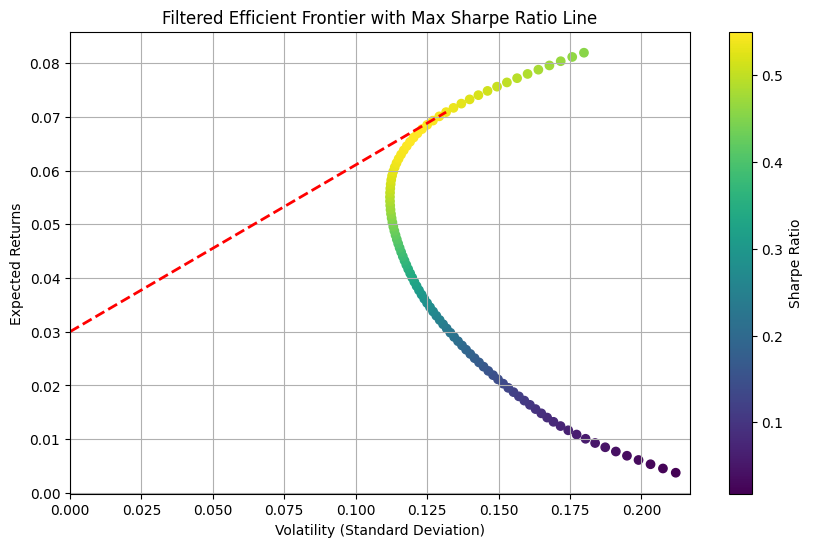

In [64]:
# Calculate Sharpe ratio for each portfolio
pf['sharpe_ratio'] = (pf['returns'] - risk_free_rate) / pf['volatility']

# Find portfolio with maximum Sharpe ratio
max_sharpe_portfolio = pf.iloc[pf['sharpe_ratio'].idxmax()]

# Calculate slope of the line from (0, risk_free) to the maximum Sharpe portfolio
slope = max_sharpe_portfolio['returns'] / max_sharpe_portfolio['volatility']

# Plotting the filtered Efficient Frontier with x-axis starting from 0 and the line
plt.figure(figsize=(10, 6))
plt.scatter(pf['volatility'], pf['returns'], c=pf['returns'] / pf['volatility'], marker='o')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Returns')
plt.title('Filtered Efficient Frontier with Max Sharpe Ratio Line')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)

# Set x-axis limit to start from 0
plt.xlim(left=0)

# Plot the line from (0, risk_free) with slope equal to the maximum Sharpe ratio
plt.plot([0, max_sharpe_portfolio['volatility']], [risk_free_rate, max_sharpe_portfolio['returns']], color='red', linestyle='--', linewidth=2)

plt.show()


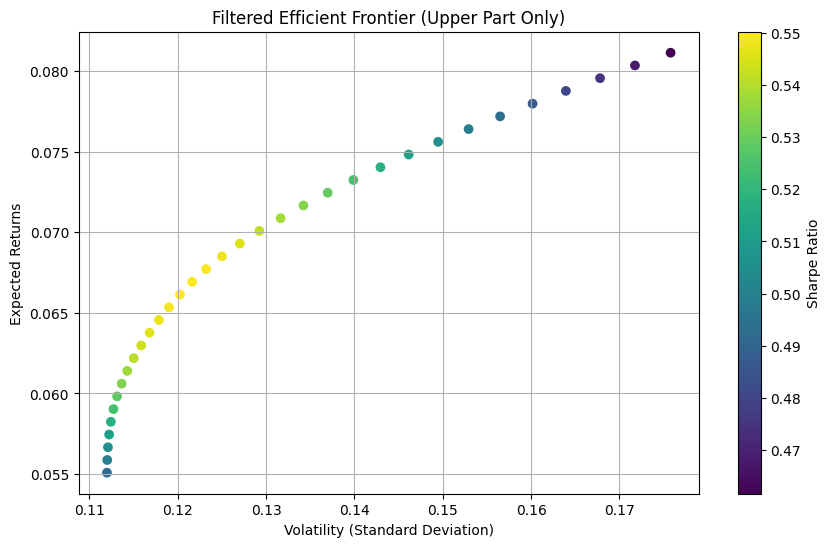

In [61]:
# Find the minimum variance portfolio
min_variance_portfolio = pf.iloc[pf['volatility'].idxmin()]

# Find the maximum return of a single asset
max_single_return = expected_returns.max()

# Filter efficient frontier to keep only the upper part
upper_efficient_frontier = pf[
    (pf['returns'] >= min_variance_portfolio['returns']) & 
    (pf['returns'] <= max_single_return)
]

# Plotting the filtered Efficient Frontier
plt.figure(figsize=(10, 6))
plt.scatter(upper_efficient_frontier['volatility'], upper_efficient_frontier['returns'], c=upper_efficient_frontier['returns'] / upper_efficient_frontier['volatility'], marker='o')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Returns')
plt.title('Filtered Efficient Frontier (Upper Part Only)')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()